In [19]:
import numpy as np
import matplotlib.pyplot as plt
import dill
import sympy
from tqdm import tqdm
import plotly
import gmsh

### Load precomputed integrals

In [20]:
lagrange_linear_poisson_matrix = dill.load(
    open("../calculations/lagrange_linear_poisson_matrix", "rb")
)
lagrange_linear_poisson_right_values = dill.load(
    open("../calculations/lagrange_linear_poisson_right_values", "rb")
)

lagrange_linear_poisson_matrix_curvilinear = dill.load(
    open("../calculations/lagrange_linear_weak_form_functional_cubic_hermite", "rb")
)
lagrange_linear_poisson_right_values_curvilinear = dill.load(
    open("../calculations/lagrange_linear_weak_form_right_part_cubic_hermite", "rb")
)

mapping_function_curved = dill.load(
    open("../calculations/lagrange_linear_mapping_function", "rb")
)

interpolation_function = dill.load(open("../calculations/lagrange_linear_basis", "rb"))


### Initialize the domain

### Run triangulation

In [21]:
gmsh.initialize()
gmsh.model.add("tri_mesh")

point_mesh_size = 0.2
point_1 = gmsh.model.geo.addPoint(0, 0, 0, point_mesh_size)
point_2 = gmsh.model.geo.addPoint(1, 0, 0, point_mesh_size)
point_3 = gmsh.model.geo.addPoint(0, 1, 0, point_mesh_size)
point_4 = gmsh.model.geo.addPoint(-1, 0, 0, point_mesh_size)
point_5 = gmsh.model.geo.addPoint(0, -1, 0, point_mesh_size)

# Define circles
arc_1 = gmsh.model.geo.addCircleArc(point_2, point_1, point_3)
arc_2 = gmsh.model.geo.addCircleArc(point_3, point_1, point_4)
arc_3 = gmsh.model.geo.addCircleArc(point_4, point_1, point_5)
arc_4 = gmsh.model.geo.addCircleArc(point_5, point_1, point_2)


circle = gmsh.model.geo.addCurveLoop([arc_1, arc_2, arc_3, arc_4])

plane = gmsh.model.geo.addPlaneSurface([circle])

gmsh.model.geo.synchronize()


physical_group_curves_tag = gmsh.model.addPhysicalGroup(1, [arc_1, arc_2, arc_3, arc_4], name="Boundary curves")
physical_group_surface_tag = gmsh.model.addPhysicalGroup(2, [plane], name="Surface")


gmsh.model.mesh.generate(2)
gmsh.fltk.run()

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Circle)
Info    : [ 30%] Meshing curve 2 (Circle)
Info    : [ 60%] Meshing curve 3 (Circle)
Info    : [ 80%] Meshing curve 4 (Circle)
Info    : Done meshing 1D (Wall 0.000283551s, CPU 0.000551s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00265083s, CPU 0.002674s)
Info    : 124 nodes 249 elements
-------------------------------------------------------
Version       : 4.13.1
License       : GNU General Public License
Build OS      : Linux64-sdk
Build date    : 20240524
Build host    : gmsh.info
Build options : 64Bit ALGLIB[contrib] ANN[contrib] Bamg Blas[petsc] Blossom Cgns DIntegration Dlopen DomHex Eigen[contrib] Fltk Gmm[contrib] Hxt Jpeg Kbipack Lapack[petsc] LinuxJoystick MathEx[contrib] Med Mesh Metis[contrib] Mmg Mpeg Netgen Nii2mesh ONELAB ONELABMetamodel OpenCASCADE OpenCASCADE-CAF OpenGL OpenMP OptHom PETSc Parser Plugins Png Post QuadMeshingTools QuadT

## Get boundary triangles

In [22]:
boundary_node_tags, boundary_node_coords = gmsh.model.mesh.getNodesForPhysicalGroup(1, physical_group_curves_tag)
surface_node_tags, points = gmsh.model.mesh.getNodesForPhysicalGroup(2, physical_group_surface_tag)
points = points.reshape(-1, 3)[:, :-1]
boundary_node_tags = boundary_node_tags - 1

element_types, element_tags, element_node_tags = gmsh.model.mesh.getElements()
triangles = [nodes for elem_type, nodes in zip(element_types, element_node_tags) if elem_type == 2][0]
triangles = triangles.reshape(-1, 3).astype(int)
triangles = triangles - 1

vertex_marker_is_boundary = np.zeros(surface_node_tags.shape[0])
vertex_marker_is_boundary[boundary_node_tags] = 1

In [23]:
is_boundary_triangle = np.zeros(triangles.shape[0])
for pidx in np.where(vertex_marker_is_boundary)[0]:
    mask = np.any(triangles == pidx, axis=-1)
    is_boundary_triangle[mask] += 1

is_boundary_triangle = (is_boundary_triangle >= 2)

### Visualize the triangulation

In [24]:
R = np.array([
    [0, -1],
    [1, 0]
])

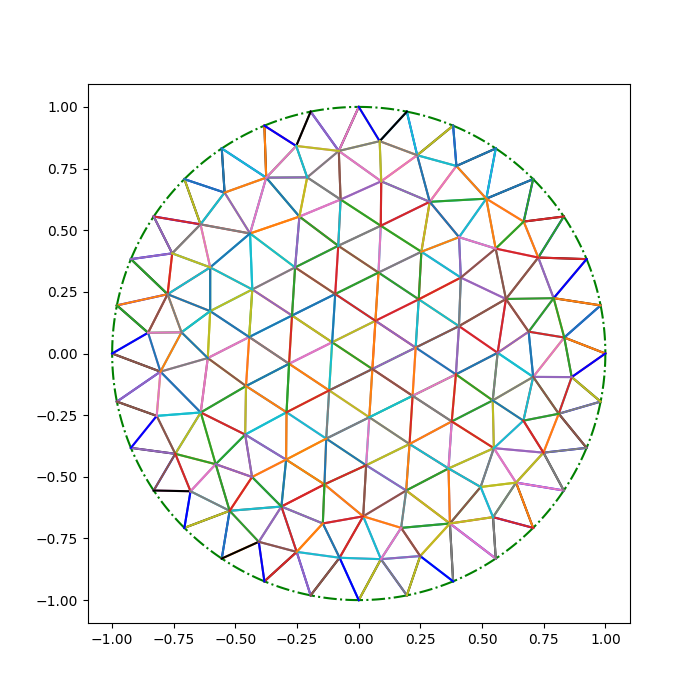

In [25]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(7, 7))
ax.axis("equal")


for tidx, element in enumerate(triangles):
    if is_boundary_triangle[tidx] == True:

        while vertex_marker_is_boundary[element][0] != 0:
            tmp = element[0]
            element[:-1] = element[1:]
            element[-1] = tmp

        tt = np.linspace(0, 1, 100)
        pts = points[element]
    
        
        n1 = pts[1] / np.linalg.norm(pts[1])
        n2 = pts[2] / np.linalg.norm(pts[2])
        a = R@n1 * np.sqrt(((points[element[1]] - points[element[2]])**2).sum())
        b = R@n2 * np.sqrt(((points[element[1]] - points[element[2]])**2).sum())
        
        v_22_1 = a[0]
        v_22_2 = a[1]
        
        v_32_1 = -b[0]
        v_32_2 = -b[1]
        

        e1_x, e1_y = mapping_function_curved(tt, 1-tt, pts[0, 0], pts[0, 1], pts[1, 0], pts[1, 1], pts[2, 0], pts[2, 1], v_22_1, v_22_2, v_32_1, v_32_2)[:, 0]
        e2_x, e2_y = mapping_function_curved(tt,    0, pts[0, 0], pts[0, 1], pts[1, 0], pts[1, 1], pts[2, 0], pts[2, 1], v_22_1, v_22_2, v_32_1, v_32_2)[:, 0]
        e3_x, e3_y = mapping_function_curved(0,    tt, pts[0, 0], pts[0, 1], pts[1, 0], pts[1, 1], pts[2, 0], pts[2, 1], v_22_1, v_22_2, v_32_1, v_32_2)[:, 0]

        ax.plot(e1_x, e1_y, color="green", ls="-.")
        ax.plot(e2_x, e2_y, color="black")
        ax.plot(e3_x, e3_y, color="blue")                
    else:
        ax.plot(*points[element[[0, 1]]].T)
        ax.plot(*points[element[[1, 2]]].T)
        ax.plot(*points[element[[0, 2]]].T)
    
plt.show()

In [26]:
x, y = sympy.symbols("x y")

In [27]:
F = sympy.Float(1)
right_vals = np.zeros((points.shape[0]))
right_vals[:] = sympy.lambdify((x, y), F)(*points.T)

In [28]:
matrix = np.zeros((points.shape[0], points.shape[0]))
b = np.zeros(points.shape[0])

for idx, element in enumerate(tqdm(triangles)):
    x1, x2, x3 = points[element[0], 0], points[element[1], 0], points[element[2], 0]
    y1, y2, y3 = points[element[0], 1], points[element[1], 1], points[element[2], 1]

    if is_boundary_triangle[idx]:
        while vertex_marker_is_boundary[element][0] != 0:
            tmp = element[0]
            element[:-1] = element[1:]
            element[-1] = tmp
            
        pts = points[element]

        n1 = pts[1] / np.linalg.norm(pts[1])
        n2 = pts[2] / np.linalg.norm(pts[2])
        aa = R@n1 * np.sqrt(((points[element[1]] - points[element[2]])**2).sum())
        bb = R@n2 * np.sqrt(((points[element[1]] - points[element[2]])**2).sum())
        
        v_22_1 = aa[0]
        v_22_2 = aa[1]
        
        v_32_1 = -bb[0]
        v_32_2 = -bb[1]

        FF = lagrange_linear_poisson_matrix_curvilinear(x1, y1, x2, y2, x3, y3, v_22_1, v_22_2, v_32_1, v_32_2)
        ff = lagrange_linear_poisson_right_values_curvilinear(x1, y1, x2, y2, x3, y3, v_22_1, v_22_2, v_32_1, v_32_2, *right_vals[element])
        

        for local_point in range(3):
            if vertex_marker_is_boundary[element[local_point]] == True:
                matrix[element[local_point], element[local_point]] = 1
                b[element[local_point]] *= 0
            else:
                for i in range(3):
                    matrix[element[local_point], element[i]] += FF[local_point, i]

                b[element[local_point]] -= ff[local_point]
                
    else:
            
        delta = x1 * y2 - x1 * y3 - x2 * y1 + x2 * y3 + x3 * y1 - x3 * y2

        P_1_x = (-y1 + y3) / delta
        P_1_y = (+x1 - x3) / delta

        P_2_x = (+y1 - y2) / delta
        P_2_y = (-x1 + x2) / delta

        arg = [P_1_x, P_2_x, P_1_y, P_2_y, *right_vals[element]]

        FF = lagrange_linear_poisson_matrix(x1, y1, x2, y2, x3, y3, )
        ff = lagrange_linear_poisson_right_values(x1, y1, x2, y2, x3, y3, *right_vals[element])

        for local_point in range(3):
            if vertex_marker_is_boundary[element[local_point]] == True:
                matrix[element[local_point], element[local_point]] = 1
                b[element[local_point]] *= 0
            else:
                for i in range(3):
                    matrix[element[local_point], element[i]] += FF[local_point, i]

                b[element[local_point]] -=  ff[local_point]

  0%|          | 0/212 [00:00<?, ?it/s]/tmp/ipykernel_19847/4079551969.py:64: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/tmp/ipykernel_19847/4079551969.py:39: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

100%|██████████| 212/212 [00:00<00:00, 15030.04it/s]


In [29]:
F = np.linalg.solve(matrix, b)

In [30]:
param = np.linspace(0, 1, 10)
tx, ty = np.meshgrid(param, param, indexing="ij")
mask = ty <= 1 - tx
tx = tx[mask]
ty = ty[mask]

In [31]:
XX, YY, ZZ = [], [], []

for idx, element in enumerate(triangles):
    x1, x2, x3 = points[element[0], 0], points[element[1], 0], points[element[2], 0]
    y1, y2, y3 = points[element[0], 1], points[element[1], 1], points[element[2], 1]


    if is_boundary_triangle[idx]:
        while vertex_marker_is_boundary[element][0] != 0:
            tmp = element[0]
            element[:-1] = element[1:]
            element[-1] = tmp
            
        pts = points[element]

        n1 = pts[1] / np.linalg.norm(pts[1])
        n2 = pts[2] / np.linalg.norm(pts[2])
        aa = R@n1 * np.sqrt(((points[element[1]] - points[element[2]])**2).sum())
        bb = R@n2 * np.sqrt(((points[element[1]] - points[element[2]])**2).sum())
        
        v_22_1 = aa[0]
        v_22_2 = aa[1]
        
        v_32_1 = -bb[0]
        v_32_2 = -bb[1]

        e1_x, e1_y = mapping_function_curved(tx, ty, 
                                      pts[0, 0], pts[0, 1], pts[1, 0], 
                                      pts[1, 1], pts[2, 0], pts[2, 1], 
                                      v_22_1, v_22_2, 
                                      v_32_1, v_32_2)[:, 0]


        XX.append(e1_x)
        YY.append(e1_y)
        
        ZZ.append(interpolation_function(tx, ty, 
                                         pts[0, 0], pts[0, 1], pts[1, 0], 
                                         pts[1, 1], pts[2, 0], pts[2, 1], 
                                         v_22_1, v_22_2, 
                                         v_32_1, v_32_2,
                                         F[element[0]], F[element[1]], F[element[2]]))
        
    else:
        XX.append(x1 + tx * (x2 - x1) + ty * (x3 - x1))
        YY.append(y1 + tx * (y2 - y1) + ty * (y3 - y1))
        ZZ.append(F[element[0]]*(1-tx-ty) + F[element[1]]*tx + F[element[2]]*ty)

In [32]:
plot_data = [
    plotly.graph_objects.Mesh3d(
                                x=xx,
                                y=yy,
                                z=zz,                                          
                                )    
    for xx, yy, zz in zip(XX, YY, ZZ) 
    ]
fig = plotly.graph_objects.Figure(data=plot_data)
fig.update_layout()


In [33]:
x = np.concatenate(XX)
y = np.concatenate(YY)
z_hat = np.concatenate(ZZ)
z = (x**2 + y**2 - 1)/4

In [34]:
d = z_hat - z

In [35]:
plot_data = [
    plotly.graph_objects.Mesh3d(
                                x=x,
                                y=y,
                                z=d,                                          
                                )    
    ]
fig = plotly.graph_objects.Figure(data=plot_data)
fig.update_layout()
